In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from fbprophet import Prophet

In [4]:
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
sales_df = pd.read_csv('train.csv') #read training file

In [6]:
sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2/5/2010,24924.50,False
1,1,1,2/12/2010,46039.49,True
2,1,1,2/19/2010,41595.55,False
3,1,1,2/26/2010,19403.54,False
4,1,1,3/5/2010,21827.90,False


In [7]:
sales_df.tail() #sales_df contains many stores and depts in the dataset

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,9/28/2012,508.37,False
421566,45,98,10/5/2012,628.10,False
421567,45,98,10/12/2012,1061.02,False
421568,45,98,10/19/2012,760.01,False
421569,45,98,10/26/2012,1076.80,False


In [8]:
# Get timeseries for one store & dept. Only getting date and weekly_Sales info here as fbprophet only 
## needs date and value to forecast. Holiday data will be used as separate dataframe

df = sales_df[(sales_df['Store']==1)&(sales_df['Dept']==1)][['Date', 'Weekly_Sales']] 

In [9]:
df.head()

,Date,Weekly_Sales
0,2/5/2010,24924.50
1,2/12/2010,46039.49
2,2/19/2010,41595.55
3,2/26/2010,19403.54
4,3/5/2010,21827.90


In [10]:
df.tail()

,Date,Weekly_Sales
138,9/28/2012,18947.81
139,10/5/2012,21904.47
140,10/12/2012,22764.01
141,10/19/2012,24185.27
142,10/26/2012,27390.81


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
Date            143 non-null object
Weekly_Sales    143 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [12]:
df['Date'] = pd.DatetimeIndex(df['Date']) #convert date to date datatype

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
Date            143 non-null datetime64[ns]
Weekly_Sales    143 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [14]:
df = df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}) #rename the cols as needed by fbprophet

In [15]:
df.head()

,ds,y
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [16]:
orig_df = df.copy()

In [17]:
#orig_df

In [18]:
# Visualize the data

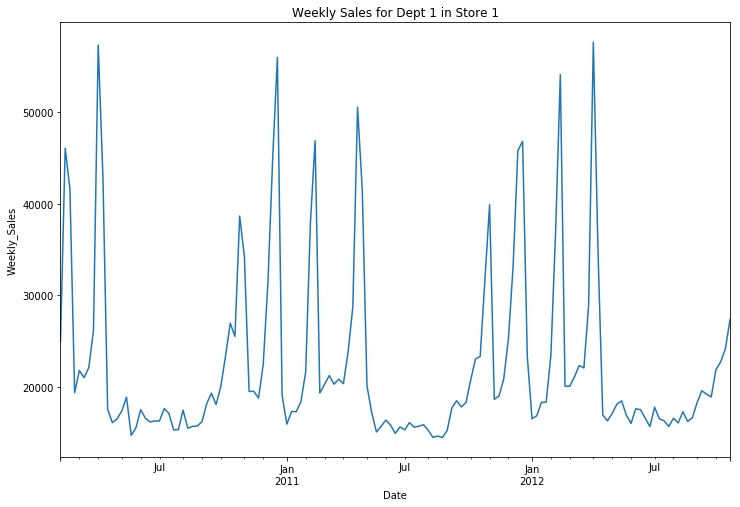

In [19]:
df.set_index('ds').y.plot(figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('Weekly_Sales')
plt.title('Weekly Sales for Dept 1 in Store 1');

In [20]:
## Get the holiday info for Store 1, Dept 1
sales_df[(sales_df['Store']==1) & (sales_df['Dept']==1)&(sales_df['IsHoliday']==True)][['Date']]

,Date
1,2/12/2010
31,9/10/2010
42,11/26/2010
47,12/31/2010
53,2/11/2011
83,9/9/2011
94,11/25/2011
99,12/30/2011
105,2/10/2012
135,9/7/2012


In [21]:
holiday_dates = sales_df[(sales_df['Store']==1) & (sales_df['Dept']==1)&(sales_df['IsHoliday']==True)][['Date']]

In [22]:
holiday_dates

,Date
1,2/12/2010
31,9/10/2010
42,11/26/2010
47,12/31/2010
53,2/11/2011
83,9/9/2011
94,11/25/2011
99,12/30/2011
105,2/10/2012
135,9/7/2012


In [23]:
holiday_dates['Date'].values

array(['2/12/2010', '9/10/2010', '11/26/2010', '12/31/2010', '2/11/2011',
       '9/9/2011', '11/25/2011', '12/30/2011', '2/10/2012', '9/7/2012'], dtype=object)

In [24]:
## Create holiday df with lower and upper window = 0, as we do not want to extend the holiday out
# to days around the given date

presidentsday_df = pd.DataFrame({
    'holiday': 'PresidentsDay',
    'ds': pd.to_datetime(['2/12/2010','2/11/2011','2/10/2012']),
    'lower_window': 0,
    'upper_window': 0
})

laborday_df = pd.DataFrame({
    'holiday': 'LaborDay',
    'ds': pd.to_datetime(['9/10/2010','9/9/2011','9/7/2012']),
    'lower_window': 0,
    'upper_window': 0
})

thanksgiving_df = pd.DataFrame({
    'holiday': 'LaborDay',
    'ds': pd.to_datetime(['11/26/2010','11/25/2011']),
    'lower_window': 0,
    'upper_window': 0
})

newyears_df = pd.DataFrame({
    'holiday': 'NewYearDay',
    'ds': pd.to_datetime(['12/31/2010','12/30/2011']),
    'lower_window': 0,
    'upper_window': 0
})


In [25]:
holidays_df = pd.concat((presidentsday_df, laborday_df, thanksgiving_df, newyears_df))

In [26]:
holidays_df

,ds,holiday,lower_window,upper_window
0,2010-02-12,PresidentsDay,0,0
1,2011-02-11,PresidentsDay,0,0
2,2012-02-10,PresidentsDay,0,0
0,2010-09-10,LaborDay,0,0
1,2011-09-09,LaborDay,0,0
2,2012-09-07,LaborDay,0,0
0,2010-11-26,LaborDay,0,0
1,2011-11-25,LaborDay,0,0
0,2010-12-31,NewYearDay,0,0
1,2011-12-30,NewYearDay,0,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
ds    143 non-null datetime64[ns]
y     143 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [28]:
## Split train and test set 
train_df = df[:100] #split train, test into 70/30 of df
test_df = df[100:]

In [29]:
train_df.head()

,ds,y
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [30]:
train_df.tail()

,ds,y
95,2011-12-02,25293.49
96,2011-12-09,33305.92
97,2011-12-16,45773.03
98,2011-12-23,46788.75
99,2011-12-30,23350.88


In [31]:
test_df.head()

,ds,y
100,2012-01-06,16567.69
101,2012-01-13,16894.40
102,2012-01-20,18365.10
103,2012-01-27,18378.16
104,2012-02-03,23510.49


In [32]:
test_df.tail()

,ds,y
138,2012-09-28,18947.81
139,2012-10-05,21904.47
140,2012-10-12,22764.01
141,2012-10-19,24185.27
142,2012-10-26,27390.81


### Using Prophet

In [33]:
#del(model)
#del(forecast)

In [34]:
# include holiday effects & yearly_seasonality as our data follows yearly seasonal pattern
model = Prophet(holidays=holidays_df, yearly_seasonality=True) 
model.add_seasonality(name='yearly', period='365.25', fourier_order=7) 

In [35]:
# Fit model on train data
model.fit(train_df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
# Define future timeframe, with 43 weeks, since this is the number of weeks we have in the test_df
future = model.make_future_dataframe(periods=43, freq='W-FRI') 

In [37]:
future.head()

,ds
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05


In [38]:
future.tail()

,ds
138,2012-09-28
139,2012-10-05
140,2012-10-12
141,2012-10-19
142,2012-10-26


In [39]:
# Use predict method to forecast for the future timeframe
forecast = model.predict(future)

In [40]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,LaborDay,LaborDay_lower,LaborDay_upper,NewYearDay,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yearly,yearly_lower,yearly_upper,yhat
138,2012-09-28,22514.952702,22514.951800,22514.953661,12859.668160,26106.650439,0.0,0.0,0.0,0.0,...,-3004.365478,-3004.365478,-3004.365478,-3004.365478,-3004.365478,-3004.365478,-3004.365478,-3004.365478,-3004.365478,19510.587224
139,2012-10-05,22511.075591,22511.074651,22511.076582,12934.377676,26197.128670,0.0,0.0,0.0,0.0,...,-2764.073527,-2764.073527,-2764.073527,-2764.073527,-2764.073527,-2764.073527,-2764.073527,-2764.073527,-2764.073527,19747.002064
140,2012-10-12,22507.198480,22507.197501,22507.199503,15397.535990,27802.676616,0.0,0.0,0.0,0.0,...,-600.516212,-600.516212,-600.516212,-600.516212,-600.516212,-600.516212,-600.516212,-600.516212,-600.516212,21906.682269
141,2012-10-19,22503.321370,22503.320345,22503.322439,20234.486183,33829.186687,0.0,0.0,0.0,0.0,...,4590.083350,4590.083350,4590.083350,4590.083350,4590.083350,4590.083350,4590.083350,4590.083350,4590.083350,27093.404719
142,2012-10-26,22499.444259,22499.443201,22499.445378,25459.795847,39122.047337,0.0,0.0,0.0,0.0,...,9972.008871,9972.008871,9972.008871,9972.008871,9972.008871,9972.008871,9972.008871,9972.008871,9972.008871,32471.453131


In [41]:
# Observe the yhat (predicted value) and yhat (upper, lower) for the last 5 recoords
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
138,2012-09-28,19510.587224,12859.668160,26106.650439
139,2012-10-05,19747.002064,12934.377676,26197.128670
140,2012-10-12,21906.682269,15397.535990,27802.676616
141,2012-10-19,27093.404719,20234.486183,33829.186687
142,2012-10-26,32471.453131,25459.795847,39122.047337


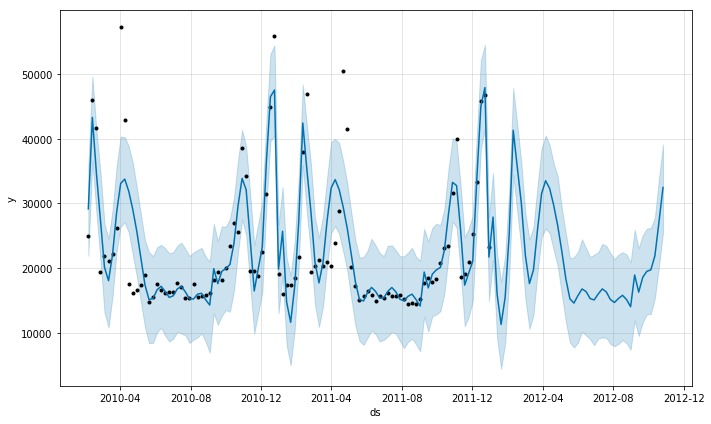

In [42]:
# Plot the forecst
model.plot(forecast);

In [43]:
#### Observed values (black dots), the forecasted values (blue line) and 
### the uncertainty intervals of our forecast(shaded blue area).

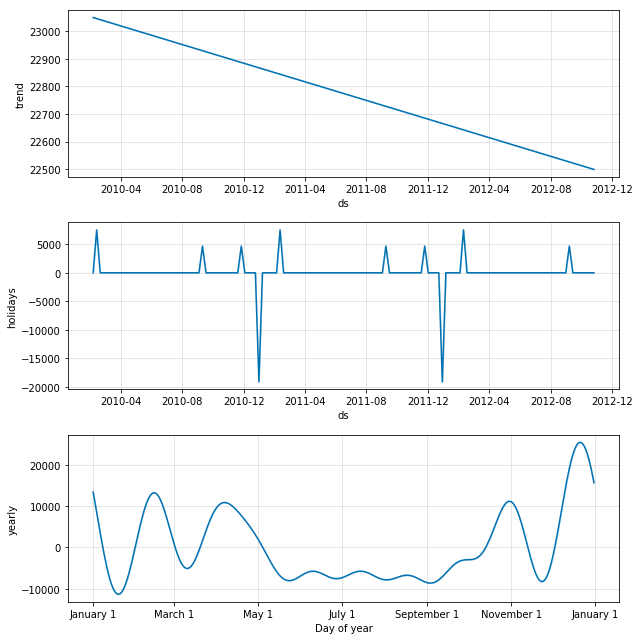

In [44]:
model.plot_components(forecast);

In [45]:
### Question: Why is th trend line going down here? Where in the original data that we see a decreasing trend?

In [46]:
metrics_df = (forecast.set_index('ds')[['yhat']][100:]).join(test_df.set_index('ds').y).reset_index()

In [47]:
metrics_df # where yhat is the predicted and y is the actual value

,ds,yhat,y
0,2012-01-06,27904.715178,16567.69
1,2012-01-13,16061.700421,16894.40
2,2012-01-20,11312.561498,18365.10
3,2012-01-27,15490.894549,18378.16
4,2012-02-03,25204.644844,23510.49
5,2012-02-10,41301.506049,36988.49
6,2012-02-17,35585.077404,54060.10
7,2012-02-24,30046.809323,20124.22
8,2012-03-02,21970.683717,20113.03
9,2012-03-09,17622.990190,21140.07


In [61]:
mse = mean_squared_error(metrics_df.y, metrics_df.yhat)
rmse = np.sqrt(mse)
print(mse)
print(rmse)

38705584.7052
6221.3812538


In [51]:
mean_absolute_error(metrics_df.y, metrics_df.yhat)

3781.8415660181904

In [52]:
#model.predictive_samples(future)

In [53]:
## Perform Cross validation to measure forecast error

In [54]:
df_cv = cross_validation(model, horizon='120 days')
# Computes forecasts from historical cutoff points. 
# Beginning from initial, makes cutoffs with a spacing of period up to (end - horizon).

In [55]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-03-11,14135.181488,8439.108118,19549.918197,21280.40,2011-03-05
1,2011-03-18,21017.493796,15561.956255,26744.912327,20334.23,2011-03-05
2,2011-03-25,34991.370553,29602.852789,40269.738710,20881.10,2011-03-05
3,2011-04-01,44481.215150,38572.395904,49622.384197,20398.09,2011-03-05
4,2011-04-08,41387.064187,36221.664607,47275.658210,23873.79,2011-03-05
5,2011-04-15,28512.649337,23076.893775,34237.001284,28762.37,2011-03-05
6,2011-04-22,16239.844437,10644.033661,22046.188068,50510.31,2011-03-05
7,2011-04-29,12272.298114,6640.595395,18027.077882,41512.39,2011-03-05
8,2011-05-06,15327.919088,9618.305729,20855.199028,20138.19,2011-03-05
9,2011-05-13,18592.634786,13294.494188,24616.700277,17235.15,2011-03-05


In [58]:
mse_cv = mean_squared_error(df_cv.y, df_cv.yhat)

In [59]:
rmse_cv = np.sqrt(mse_cv)
print(rmse_cv)

7188.98179937


In [60]:
mean_absolute_error(df_cv.y, df_cv.yhat)

3563.2692841986791